In [153]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist

In [154]:
def load_dataset():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0
    y_train_oh = np.zeros((len(y_train), 10), dtype=np.float32)
    y_train_oh[np.arange(len(y_train)), y_train] = 1.0
    y_test_oh = np.zeros((len(y_test), 10), dtype=np.float32)
    y_test_oh[np.arange(len(y_test)), y_test] = 1.0
    return x_train, y_train_oh, x_test, y_test_oh, y_test

In [155]:
def data_loader(x, y, batch_size, shuffle=True, drop_last=False):
    num_samples = x.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        if drop_last and (end_idx - start_idx) < batch_size:
            continue
        batch_indices = indices[start_idx:end_idx]
        yield x[batch_indices], y[batch_indices]

In [156]:
class Tensor:
    def __init__(self, data, requires_grad=False, creator=None):
        self.data = data.astype(np.float32)
        self.requires_grad = requires_grad
        self.creator = creator
        self.grad = None

    def backward(self, grad=None):
        if grad is None and self.data.size == 1:
            grad = np.ones_like(self.data)
        if self.requires_grad:
            self.grad = grad if self.grad is None else self.grad + grad
        if self.creator and self.creator.input.requires_grad:
            grad_input = self.creator.backward(self.grad)
            self.creator.input.backward(grad_input)

    def zero_grad(self):
        self.grad = None

In [157]:
class Parameter(Tensor):
    def __init__(self, data, requires_grad=True):
        super().__init__(data, requires_grad=requires_grad)

In [158]:
class Module:
    def __init__(self):
        self._modules = {}
        self._parameters = {}
        self.training = True

    def __setattr__(self, name, value):
        if isinstance(value, Module):
            self._modules[name] = value
            object.__setattr__(self, name, value)
        elif isinstance(value, Parameter):
            self._parameters[name] = value
            object.__setattr__(self, name, value)
        else:
            object.__setattr__(self, name, value)

    def parameters(self):
        params = []
        for param in self._parameters.values():
            if param.requires_grad:
                params.append(param)
        for module in self._modules.values():
            params.extend(module.parameters())
        return params

    def zero_grad(self):
        for param in self.parameters():
            param.zero_grad()

    def train(self):
        self.training = True
        for module in self._modules.values():
            module.train()

    def eval(self):
        self.training = False
        for module in self._modules.values():
            module.eval()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def save_weights(self, path):
        state_dict = {}
        for name, param in self._parameters.items():
            state_dict[name] = param.data
        for name, module in self._modules.items():
            for sub_name, sub_param in module._parameters.items():
                state_dict[f"{name}.{sub_name}"] = sub_param.data
        np.savez(path, **state_dict)

    def load_weights(self, path):
        data = np.load(path)
        for name, param in self._parameters.items():
            param.data = data[name]
        for name, module in self._modules.items():
            for sub_name, sub_param in module._parameters.items():
                sub_param.data = data[f"{name}.{sub_name}"]

In [159]:
class SGD:
    def __init__(self, parameters, lr=0.1):
        self.parameters = parameters
        self.lr = lr

    def step(self):
        for p in self.parameters:
            if p.grad is not None:
                p.data -= self.lr * p.grad

    def zero_grad(self):
        for p in self.parameters:
            p.zero_grad()

In [160]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        lim = np.sqrt(6 / (in_features + out_features))
        self.weight = Parameter(
            np.random.uniform(-lim, lim, (in_features, out_features)).astype(
                np.float32
            )
        )
        self.bias = Parameter(np.zeros(out_features, dtype=np.float32))
        self.input = None

    def forward(self, x: Tensor):
        self.input = x
        out = x.data @ self.weight.data + self.bias.data
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        grad_input = grad_output @ self.weight.data.T
        self.weight.grad = self.input.data.T @ grad_output
        self.bias.grad = np.sum(grad_output, axis=0)
        return grad_input

In [161]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        self.input = None

    def forward(self, x: Tensor):
        self.input = x
        out = np.maximum(0, x.data)
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        return grad_output * (self.input.data > 0).astype(np.float32)

In [162]:
class BatchNorm(Module):
    def __init__(self, dim, momentum=0.9, eps=1e-5):
        super().__init__()
        self.gamma = Parameter(np.ones(dim, dtype=np.float32))
        self.beta = Parameter(np.zeros(dim, dtype=np.float32))
        self.running_mean = np.zeros(dim, dtype=np.float32)
        self.running_var = np.ones(dim, dtype=np.float32)
        self.eps = eps
        self.momentum = momentum
        self.batch_mean = None
        self.batch_var = None
        self.input = None
        self.x_hat = None

    def forward(self, x: Tensor):
        self.input = x
        if self.training:
            self.batch_mean = x.data.mean(axis=0)
            self.batch_var = x.data.var(axis=0)
            self.running_mean = (
                self.momentum * self.running_mean
                + (1 - self.momentum) * self.batch_mean
            )
            self.running_var = (
                self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
            )
            self.x_hat = (x.data - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
        else:
            self.x_hat = (x.data - self.running_mean) / np.sqrt(
                self.running_var + self.eps
            )
        out = self.gamma.data * self.x_hat + self.beta.data
        return Tensor(out, requires_grad=True, creator=self)

    def backward(self, grad_output):
        self.gamma.grad = np.sum(grad_output * self.x_hat, axis=0)
        self.beta.grad = np.sum(grad_output, axis=0)
        mean_grad_output = np.mean(grad_output, axis=0)
        mean_grad_output_x_hat = np.mean(grad_output * self.x_hat, axis=0)
        dx = (self.gamma.data / np.sqrt(self.batch_var + self.eps)) * (
            grad_output - mean_grad_output - self.x_hat * mean_grad_output_x_hat
        )
        return dx

In [163]:
class SoftmaxCrossEntropy(Module):
    def __init__(self):
        super().__init__()
        self.softmax = None
        self.targets = None
        self.input = None

    def forward(self, logits: Tensor, targets: np.ndarray):
        self.input = logits
        self.targets = targets
        exps = np.exp(logits.data - np.max(logits.data, axis=1, keepdims=True))
        self.softmax = exps / np.sum(exps, axis=1, keepdims=True)
        N = logits.data.shape[0]
        correct_log_probs = -np.log(
            self.softmax[np.arange(N), np.argmax(targets, axis=1)] + 1e-12
        )
        return Tensor(np.mean(correct_log_probs), requires_grad=True, creator=self)

    def backward(self, grad_output):
        grad = (self.softmax - self.targets) / self.softmax.shape[0]
        return grad * grad_output

In [164]:
class DistillationLoss(Module):
    def __init__(self, temperature=2.0, alpha=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.student_softmax = None
        self.teacher_softmax = None
        self.targets = None
        self.input = None
        self.ce_loss_fn = SoftmaxCrossEntropy()

    def softmax(self, logits):
        exps = np.exp(logits / self.temperature)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(
        self, student_logits: Tensor, teacher_logits: Tensor, targets: np.ndarray
    ):
        self.input = student_logits
        self.targets = targets
        self.student_softmax = self.softmax(student_logits.data)
        self.teacher_softmax = self.softmax(teacher_logits.data)
        kl_loss = np.mean(
            np.sum(
                self.teacher_softmax
                * (
                    np.log(self.teacher_softmax + 1e-12)
                    - np.log(self.student_softmax + 1e-12)
                ),
                axis=1,
            )
        ) * (self.temperature**2)
        ce_loss = self.ce_loss_fn(student_logits, targets).data
        loss = self.alpha * kl_loss + (1 - self.alpha) * ce_loss
        return Tensor(loss, requires_grad=True, creator=self)

    def backward(self, grad_output):
        grad = (self.student_softmax - self.teacher_softmax) / (
            self.student_softmax.shape[0] * self.temperature
        )
        ce_grad = self.ce_loss_fn.backward(grad)
        combined_grad = self.alpha * grad + (1 - self.alpha) * ce_grad
        return combined_grad * grad_output

In [165]:
class Teacher(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 256)
        self.bn1 = BatchNorm(256)
        self.relu1 = ReLU()
        self.fc2 = Linear(256, 128)
        self.bn2 = BatchNorm(128)
        self.relu2 = ReLU()
        self.fc3 = Linear(128, 64)
        self.bn3 = BatchNorm(64)
        self.relu3 = ReLU()
        self.fc4 = Linear(64, 32)
        self.bn4 = BatchNorm(32)
        self.relu4 = ReLU()
        self.fc5 = Linear(32, 16)
        self.bn5 = BatchNorm(16)
        self.relu5 = ReLU()
        self.fc6 = Linear(16, 10)

    def forward(self, x: Tensor):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        return x

In [166]:
class Student(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 256)
        self.bn1 = BatchNorm(256)
        self.relu1 = ReLU()
        self.fc2 = Linear(256, 128)
        self.bn2 = BatchNorm(128)
        self.relu2 = ReLU()
        self.fc3 = Linear(128, 64)
        self.bn3 = BatchNorm(64)
        self.relu3 = ReLU()
        self.fc4 = Linear(64, 10)

    def forward(self, x: Tensor):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

In [167]:
def train(
    model,
    optimizer,
    loss_fn,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=10,
    batch_size=64,
):
    loss_history = []
    test_loss_history = []
    acc_history = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in data_loader(x_train, y_train, batch_size, shuffle=True, drop_last=True):
            x_tensor = Tensor(x_batch, requires_grad=True)
            probs = model(x_tensor)
            loss = loss_fn(probs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data
            num_batches += 1
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        model.eval()
        x_test_tensor = Tensor(x_test, requires_grad=False)
        preds = model(x_test_tensor)
        test_loss = loss_fn(preds, y_test).data
        test_loss_history.append(test_loss)
        acc = (np.argmax(preds.data, axis=1) == np.argmax(y_test, axis=1)).mean()
        acc_history.append(acc)
        print(
            f"Teacher Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.4f}"
        )
    return loss_history, test_loss_history, acc_history

In [168]:
def train_student(
    student,
    teacher,
    optimizer,
    loss_fn,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=10,
    batch_size=64,
):
    loss_history = []
    test_loss_history = []
    acc_history = []
    teacher.eval()
    for epoch in range(epochs):
        student.train()
        epoch_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in data_loader(x_train, y_train, batch_size, shuffle=True, drop_last=True):
            x_tensor = Tensor(x_batch, requires_grad=True)
            student_logits = student(x_tensor)
            teacher_logits = teacher(Tensor(x_batch, requires_grad=False))
            loss = loss_fn(student_logits, teacher_logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data
            num_batches += 1
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        student.eval()
        x_test_tensor = Tensor(x_test, requires_grad=False)
        preds = student(x_test_tensor)
        test_loss_fn = SoftmaxCrossEntropy()
        test_loss = test_loss_fn(preds, y_test).data
        test_loss_history.append(test_loss)
        acc = (np.argmax(preds.data, axis=1) == np.argmax(y_test, axis=1)).mean()
        acc_history.append(acc)
        print(
            f"Student Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.4f}"
        )
    return loss_history, test_loss_history, acc_history

Teacher Epoch 1/10 | Train Loss: 0.3050 | Test Loss: 0.1296 | Test Acc: 0.9616
Teacher Epoch 2/10 | Train Loss: 0.1164 | Test Loss: 0.0837 | Test Acc: 0.9749
Teacher Epoch 3/10 | Train Loss: 0.0800 | Test Loss: 0.0736 | Test Acc: 0.9772
Teacher Epoch 4/10 | Train Loss: 0.0625 | Test Loss: 0.0642 | Test Acc: 0.9795
Teacher Epoch 5/10 | Train Loss: 0.0489 | Test Loss: 0.0651 | Test Acc: 0.9806
Teacher Epoch 6/10 | Train Loss: 0.0418 | Test Loss: 0.0701 | Test Acc: 0.9810
Teacher Epoch 7/10 | Train Loss: 0.0346 | Test Loss: 0.0645 | Test Acc: 0.9817
Teacher Epoch 8/10 | Train Loss: 0.0304 | Test Loss: 0.0675 | Test Acc: 0.9803
Teacher Epoch 9/10 | Train Loss: 0.0254 | Test Loss: 0.0683 | Test Acc: 0.9808
Teacher Epoch 10/10 | Train Loss: 0.0225 | Test Loss: 0.0695 | Test Acc: 0.9814


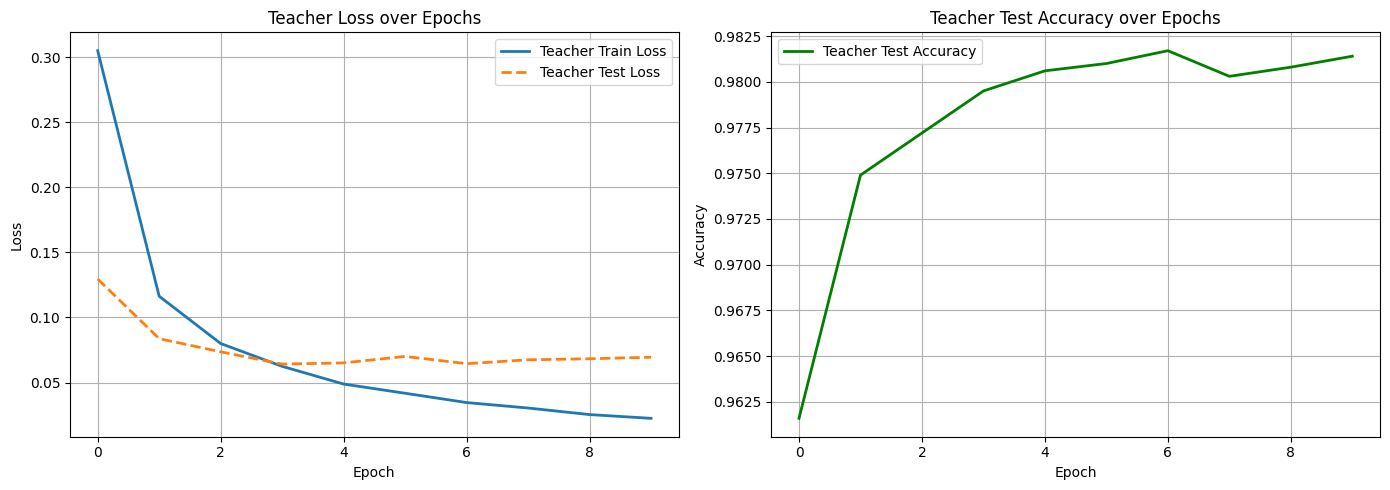

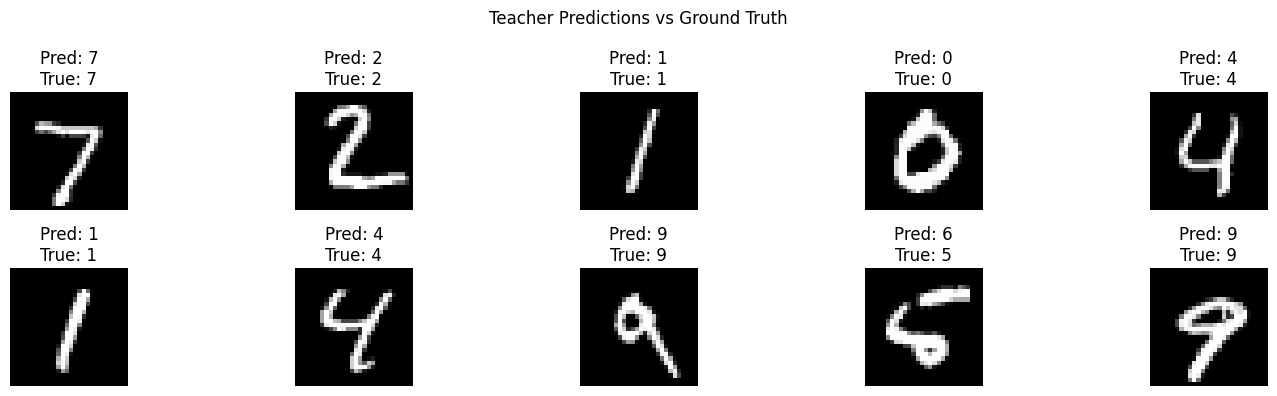

In [169]:
x_train, y_train_oh, x_test, y_test_oh, y_test = load_dataset()
model = Teacher()
optimizer = SGD(model.parameters(), lr=0.1)
loss_fn = SoftmaxCrossEntropy()
teacher_loss_history, teacher_test_loss_history, teacher_acc_history = train(
    model,
    optimizer,
    loss_fn,
    x_train,
    y_train_oh,
    x_test,
    y_test_oh,
    epochs=10,
    batch_size=64,
)
model.save_weights("teacher_weights.npz")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(teacher_loss_history, label="Teacher Train Loss", linewidth=2)
plt.plot(
    teacher_test_loss_history, label="Teacher Test Loss", linewidth=2, linestyle="--"
)
plt.title("Teacher Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(teacher_acc_history, label="Teacher Test Accuracy", color="green", linewidth=2)
plt.title("Teacher Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

model.eval()
logits = model(Tensor(x_test[:10], requires_grad=False))
predictions = np.argmax(logits.data, axis=1)
plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[i]}\nTrue: {y_test[i]}")
    plt.axis("off")
plt.suptitle("Teacher Predictions vs Ground Truth")
plt.tight_layout()
plt.show()

Student Epoch 1/10 | Train Loss: 2.8424 | Test Loss: 1.1588 | Test Acc: 0.6906
Student Epoch 2/10 | Train Loss: 1.2862 | Test Loss: 1.0178 | Test Acc: 0.7486
Student Epoch 3/10 | Train Loss: 1.0284 | Test Loss: 0.9470 | Test Acc: 0.7661
Student Epoch 4/10 | Train Loss: 0.9219 | Test Loss: 0.8887 | Test Acc: 0.7741
Student Epoch 5/10 | Train Loss: 0.8487 | Test Loss: 0.9005 | Test Acc: 0.7735
Student Epoch 6/10 | Train Loss: 0.8092 | Test Loss: 0.9085 | Test Acc: 0.7719
Student Epoch 7/10 | Train Loss: 0.7628 | Test Loss: 0.8886 | Test Acc: 0.7745
Student Epoch 8/10 | Train Loss: 0.7435 | Test Loss: 0.8394 | Test Acc: 0.7892
Student Epoch 9/10 | Train Loss: 0.7243 | Test Loss: 0.8467 | Test Acc: 0.7841
Student Epoch 10/10 | Train Loss: 0.7067 | Test Loss: 0.8422 | Test Acc: 0.7862


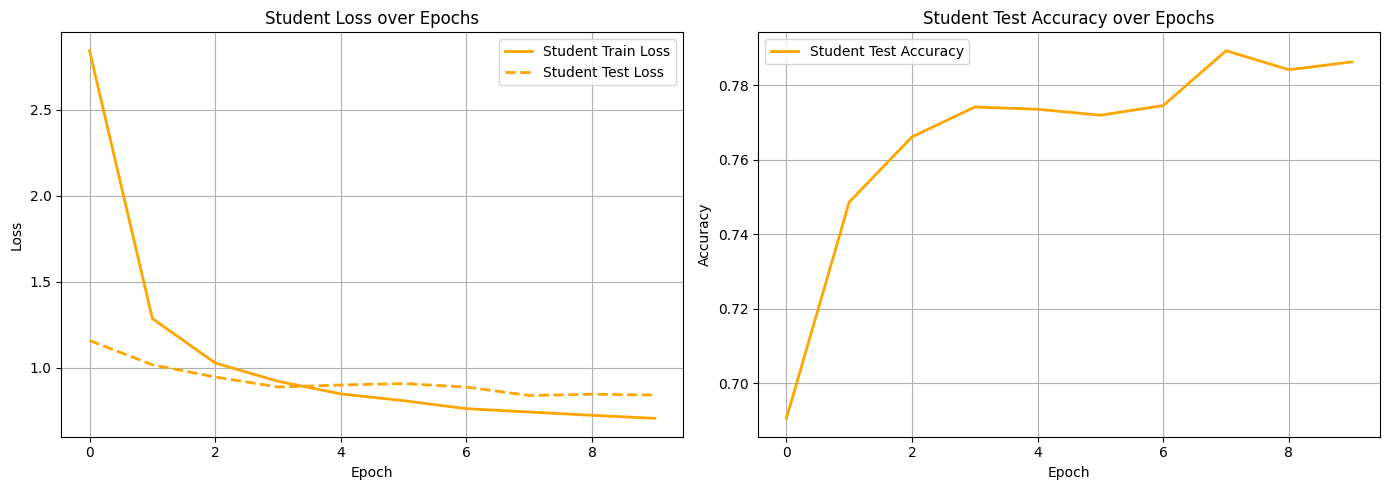

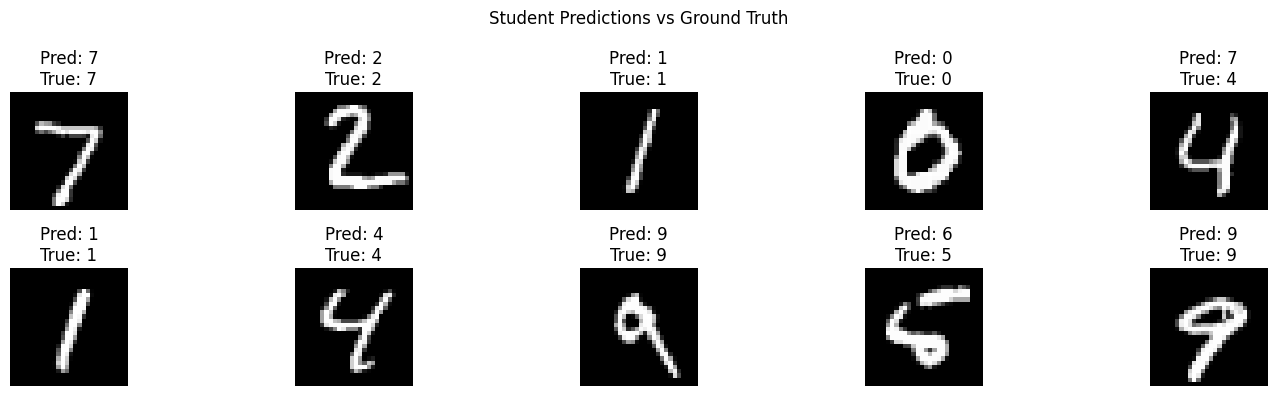

In [170]:
x_train, y_train_oh, x_test, y_test_oh, y_test = load_dataset()
teacher = Teacher()
teacher.load_weights("teacher_weights.npz")
student = Student()
optimizer_student = SGD(student.parameters(), lr=0.1)
loss_fn_distill = DistillationLoss(temperature=5.0, alpha=0.7)
student_loss_history, student_test_loss_history, student_acc_history = train_student(
    student,
    teacher,
    optimizer_student,
    loss_fn_distill,
    x_train,
    y_train_oh,
    x_test,
    y_test_oh,
    epochs=10,
    batch_size=64,
)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(student_loss_history, label="Student Train Loss", linewidth=2, color="orange")
plt.plot(
    student_test_loss_history,
    label="Student Test Loss",
    linewidth=2,
    linestyle="--",
    color="orange",
)
plt.title("Student Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(
    student_acc_history, label="Student Test Accuracy", color="orange", linewidth=2
)
plt.title("Student Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

student.eval()
logits = student(Tensor(x_test[:10], requires_grad=False))
predictions = np.argmax(logits.data, axis=1)
plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[i]}\nTrue: {y_test[i]}")
    plt.axis("off")
plt.suptitle("Student Predictions vs Ground Truth")
plt.tight_layout()
plt.show()